In [16]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
import plotly

In [17]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [18]:

fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:,1]

    data=(data - np.min(data)) / (np.max(data) - np.min(data))
    
    n_samples_resampled = int(len(data) * (fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [19]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 

        data = np.loadtxt(nombre)
        data=(data - np.min(data)) / (np.max(data) - np.min(data))
        Datos[i]=data

        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
        welch_datos[i]=welch_data

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [29]:
Params={'L': 27, 'P': 0.40348515928660067, 'Inh': 0.2765131596042354, 'Trest': -6.860559142483313, 'Trelative': 3.0032127538132514, 'C_h': 11.333370739353345, 'Tipo_red': 0}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030,2]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


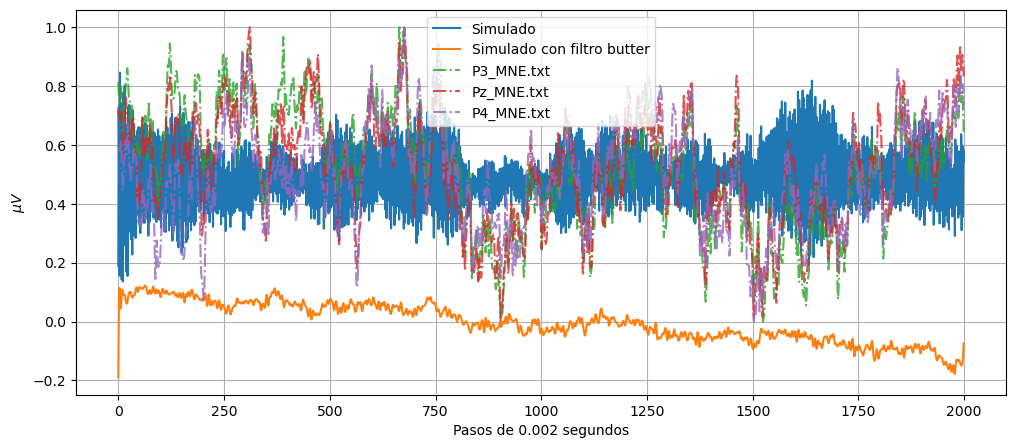

In [30]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"],label="Simulado con filtro butter")
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']
Delta [-46.186215678333404, 3.276680628883568] ---- [-26.27315661   0.        ]
Theta [-48.26070526839557, 1.7725498427411672] ---- [-30.06923771   0.        ]
Alpha [-52.264149943388524, 2.681161417064152] ---- [-31.73274975   1.28765238]
Beta [-58.11093521480361, 0.8515802692599491] ---- [-39.17635026   1.54922654]


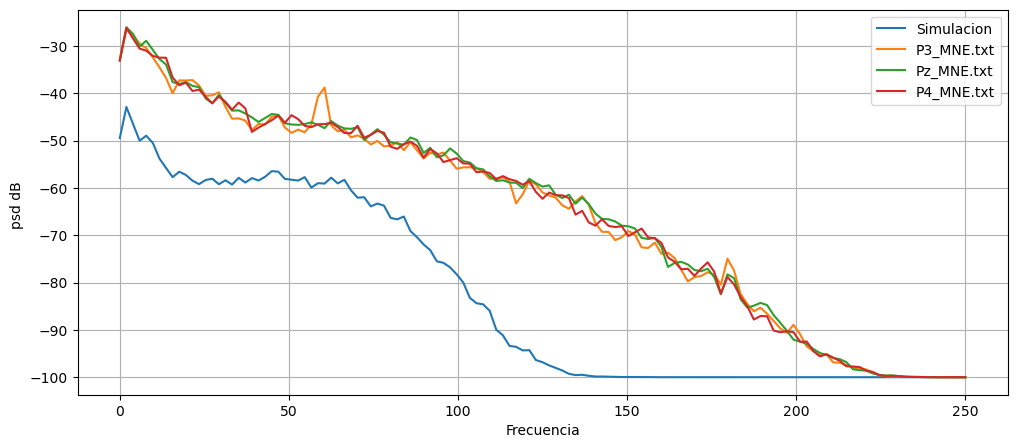

In [31]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["main_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["main_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["main_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["main_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [33]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 20.0)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        difference = (np.sum(np.abs(dif_Delta)) +
                            np.sum(np.abs(dif_Theta)) +
                            np.sum(np.abs(dif_Alpha)) +
                            np.sum(np.abs(dif_Beta)))

        trial.report(difference, step=trial.number)
        
        
        return difference
    else:
        return float('inf') 
    
# Create and optimize the study
study = optuna.create_study(study_name='4bandas_SW_Normal_min_max', 
                            storage='sqlite:///Estudios/4bandas_SW_Normal_min_max.db', 
                            load_if_exists=True)

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-10-04 12:34:03,963] A new study created in RDB with name: 4bandas_SW_Normal_min_max
[I 2024-10-04 12:34:04,261] Trial 0 finished with value: 70.77333070115232 and parameters: {'L': 11, 'P': 0.5378820066001876, 'Inh': 0.11158015296723045, 'Trest': -2.077022723761333, 'Trelative': 2.355734188974073, 'C_h': 8.350779674722338, 'Tipo_red': 2}. Best is trial 0 with value: 70.77333070115232.
[I 2024-10-04 12:34:04,648] Trial 1 finished with value: 154.18481166228452 and parameters: {'L': 24, 'P': 0.639931935348387, 'Inh': 0.1266069015560226, 'Trest': -4.686478322078083, 'Trelative': -2.088221983323957, 'C_h': 14.358788130205, 'Tipo_red': 2}. Best is trial 0 with value: 70.77333070115232.
/tmp/ipykernel_4525/2121854375.py:26: RuntimeWarning:

invalid value encountered in divide

[I 2024-10-04 12:34:10,074] Trial 2 finished with value: inf and parameters: {'L': 41, 'P': 0.8251159310268997, 'Inh': 0.07438810390037442, 'Trest': 6.734571225032255, 'Trelative': 13.606652273236417, 'C_h': 5.

KeyboardInterrupt: 

In [34]:
print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


4bandas_SW_Normal_min_max

Trial 1:
Params: {'L': 46, 'P': 0.3441133919136471, 'Inh': 0.10742441727119162, 'Trest': 0.5895158317534621, 'Trelative': 0.9675020949848956, 'C_h': 5.854659922174529, 'Tipo_red': 1}
Value: 15.997260427977245

Trial 2:
Params: {'L': 45, 'P': 0.4038450256357803, 'Inh': 0.10067168033978335, 'Trest': 0.35409378232954225, 'Trelative': 0.8143951302838064, 'C_h': 7.4485531503094595, 'Tipo_red': 1}
Value: 16.985461595766445

Trial 3:
Params: {'L': 49, 'P': 0.40099438718485453, 'Inh': 0.1329248294436745, 'Trest': 0.2880270613154533, 'Trelative': 0.6305962589948431, 'C_h': 5.841344206910967, 'Tipo_red': 2}
Value: 17.01084381560574

Trial 4:
Params: {'L': 45, 'P': 0.46649873177083323, 'Inh': 0.061211440588608404, 'Trest': 0.038938803927119826, 'Trelative': 0.8149149278275046, 'C_h': 8.796568287979245, 'Tipo_red': 1}
Value: 17.139644220795937

Trial 5:
Params: {'L': 50, 'P': 0.3845835074913614, 'Inh': 0.05097546196958769, 'Trest': 0.6635036546187695, 'Trelative': 0.9574

In [61]:
vis.plot_param_importances(study)

In [62]:
vis.plot_parallel_coordinate(study)

In [63]:
optuna.visualization.plot_slice(study)